In [ ]:
pip install pytorch-pretrained-bert

## Import libraries

In [ ]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from scipy import sparse
from sklearn.svm import LinearSVC
import json
from sklearn.model_selection import train_test_split
import copy
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils.validation import check_X_y, check_is_fitted

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score

In [ ]:
import pandas as pd
df = pd.read_csv("Reviews.csv",nrows=1000)
#df = df['Review_text']
df.drop(['Id','ProductId', 'UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time'], axis=1, inplace=True)
df

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...
...,...,...
995,Hot & Flavorful,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...
996,Great Hot Sauce and people who run it!,"Man what can i say, this salsa is the bomb!! i..."
997,this sauce is the shiznit,this sauce is so good with just about anything...
998,Not Hot,Not hot at all. Like the other low star review...


In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb=LabelEncoder()

#df['rating']=lb.fit_transform(df['Rating'])


## Preprocessing the data

In [ ]:
#df["review"] = df["Review_text"]

df["review"] = df["Text"].str.lower()


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["review"] = df["review"].apply(lambda text: remove_stopwords(text))
df.head()

,Summary,Text,review
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts.....
2,"""Delight"" says it all",This is a confection that has been around a fe...,"confection around centuries. light, pillowy ci..."
3,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price. wide assortment yummy...


In [ ]:
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["review"] = df["review"].apply(lambda text: remove_punctuation(text))

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df["review"] = df["review"].apply(lambda text: remove_emoji(text))

In [ ]:
def remove_urls(text):
  
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    try:
        return url_pattern.sub(r'', text)
    except:
        print(text)
    
df["review"] = df["review"].apply(lambda text: remove_urls(text))
df

,Summary,Text,review
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanutsth...
2,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...
...,...,...,...
995,Hot & Flavorful,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,black market hot sauce wonderful husband loves...
996,Great Hot Sauce and people who run it!,"Man what can i say, this salsa is the bomb!! i...",man say salsa bomb different kinds almost ever...
997,this sauce is the shiznit,this sauce is so good with just about anything...,sauce good anything like adding asian food any...
998,Not Hot,Not hot at all. Like the other low star review...,hot all like low star reviewer got suckered se...


In [ ]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

df["review"] = df["review"].apply(lambda text: remove_html(text))


## Tokenize the reviews using BERT

In [ ]:
# from nltk import word_tokenize 
# df['token'] = [word_tokenize(sent) for sent in df['review']]

df['token'] = ["[CLS] " +item + " [SEP]" for item in df['review']]
from pytorch_pretrained_bert import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
df['token'] = [tokenizer.tokenize(item) for item in df['token']]

ModuleNotFoundError: ignored

## Check the length of each review

In [ ]:
token = []
neglected = []
size = df['token'].size
for i in range (0,len(df['token'])):
    if len(df['token'][i]) < 300  :
        token.append(i)
    else:
        neglected.append(i)

In [ ]:
#neglected

In [ ]:
df = df.drop(745)

In [ ]:
df = df.drop(539)

In [ ]:
for i in(neglected):
    df= df.drop(i)


In [ ]:
df = df.reset_index(drop=True)


In [ ]:

from nltk.tokenize import sent_tokenize
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np

# In[ ]:


def bertSent_embeding(sentences):
    """
    Input a list of sentence tokens
    
    Output a list of latent vectors, each vector is a sentence representation
    
    Note: Bert model produce 12 layers of latent vector, the 'last layer' method is used here,
          other choices includes average last 4 layers, average all layers, etc.
    
    """
    ## Add sentence head and tail as BERT requested
    marked_sent = ["[CLS] " +item + " [SEP]" for item in sentences]
    
    ## USE Bert tokenizization 
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokenized_sent = [tokenizer.tokenize(item) for item in marked_sent]
    
    ## index to BERT vocabulary
    indexed_tokens = [tokenizer.convert_tokens_to_ids(item) for item in tokenized_sent]
    tokens_tensor = [torch.tensor([item]) for item in indexed_tokens]
    
    ## add segment id as BERT requested
    segments_ids = [[1] * len(item) for ind,item in enumerate(tokenized_sent)]
    segments_tensors = [torch.tensor([item]) for item in segments_ids]
    
    ## load BERT base model and set to evaluation mode
    bert_model = BertModel.from_pretrained('bert-base-uncased')
    bert_model.eval()
    
    ## Output 12 layers of latent vector
    assert len(tokens_tensor) == len(segments_tensors)
    encoded_layers_list = []
    for i in range(len(tokens_tensor)):
        with torch.no_grad():
            encoded_layers, _ = bert_model(tokens_tensor[i], segments_tensors[i])
        encoded_layers_list.append(encoded_layers)
    
    ## Use only the last layer vetcor, other choice available
    token_vecs_list = [layers[11][0] for layers in encoded_layers_list]
    
    ## Pooling word vector to sentence vector, use mean pooling, other choice available
    sentence_embedding_list = [torch.mean(vec, dim=0).numpy() for vec in token_vecs_list]
    
    
    
    return sentence_embedding_list




def kmeans_sumIndex(sentence_embedding_list):
    """
    Input a list of embeded sentence vectors
    
    Output an list of indices of sentence in the paragraph, represent the clustering of key sentences
    
    Note: Kmeans is used here for clustering
    
    """
    #n_clusters = np.ceil(len(sentence_embedding_list)**0.5)
    n_clusters = 15
    kmeans = KMeans(n_clusters=int(n_clusters))
    kmeans = kmeans.fit(sentence_embedding_list)
    
    sum_index,_ = pairwise_distances_argmin_min(kmeans.cluster_centers_, sentence_embedding_list,metric='euclidean')
    
    sum_index = sorted(sum_index)
    
    return (sum_index,kmeans)




# def bertSummarize(text):
#     """
#     Input a paragraph as string
    
#     Output the summary including a few key sentences using BERT sentence embedding and clustering
#     """
#     sentences = sent_tokenize(text)
    
#     sentence_embedding_list = bertSent_embeding(sentences)
#     sum_index = kmeans_sumIndex(sentence_embedding_list)
    
#     summary = ' '.join([sentences[ind] for ind in sum_index])
    
#     return summary

## BERT embedding for representation

In [ ]:
marked_sent = ["[CLS] " +item + " [SEP]" for item in df['review']]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenized_sent = [tokenizer.tokenize(item) for item in marked_sent]

100%|██████████| 231508/231508 [00:00<00:00, 4441422.74B/s]


In [ ]:
segments_ids = [[1] * len(item) for ind,item in enumerate(tokenized_sent)]
segments_tensors = [torch.tensor([item]) for item in segments_ids]


In [ ]:
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

100%|██████████| 407873900/407873900 [00:07<00:00, 57422098.74B/s]


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

In [ ]:
indexed_tokens = [tokenizer.convert_tokens_to_ids(item) for item in tokenized_sent]

tokens_tensor = [torch.tensor([item]) for item in indexed_tokens]


In [ ]:
assert len(tokens_tensor) == len(segments_tensors)
encoded_layers_list = []
for i in range(len(tokens_tensor)):
    with torch.no_grad():
        encoded_layers, _ = bert_model(tokens_tensor[i], segments_tensors[i])
    encoded_layers_list.append(encoded_layers)

In [ ]:
  ## Use only the last layer vetcor, other choice available
#token_vecs_list = [layers[11][0] for layers in encoded_layers_list]
token_vecs_list = [((layers[-4:][0]).sum(0)) for layers in encoded_layers_list]

#summed_last_4_layers = torch.stack(encoded_layers[-4:]).sum(0)
    
    ## Pooling word vector to sentence vector, use mean pooling, other choice available
sentence_embedding_list = [torch.mean(vec, dim=0).numpy() for vec in token_vecs_list]


In [ ]:
tokens_tensor

[tensor([[  101,  4149,  2195,  8995,  3012, 27141,  3899,  2833,  3688,  2179,
           2204,  3737,  4031,  3504,  2066, 20717, 13995,  6240, 14747,  2488,
          18604, 10346,  6799,  2100,  9120,  2015,  4031,  2488,  2087,   102]]),
 tensor([[  101,  4031,  3369, 12599, 18414, 13344,  5474,  2098, 27613, 10760,
          27613,  2941,  2235,  7451,  4895, 12002,  3064,  2469,  7561, 21431,
           3832,  5050,  4031, 18414, 13344,   102]]),
 tensor([[  101,  2559,  3595, 21774,  6487,  4183, 17854,  2378,  2903,  2179,
           2009,  2288,  2804,  7117,  5404, 14817,  3641,  2029,  2204,  2081,
           9115, 14904, 14894, 20632,   102]]),
 tensor([[  101,  2307, 11937, 16329,  2307,  3976,  2898, 26285,  9805, 18879,
          11937, 16329,  6959,  4248, 11937, 16329,  7089,  3066,   102]]),
 tensor([[  101,  2288,  3748,  2606, 11937, 16329,  3641,  2274,  9044,  4524,
          11937, 16329, 22249,  2116, 26389,  2300, 10199,  2239,  7117,  5404,
          11463,  

## PCA

## scaling the embedding matrix and using PCA to reduce the dimensionlaity

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(sentence_embedding_list)
#sentence_embedding_list = pd.DataFrame(sentence_embedding_list)


In [ ]:
# from sklearn.decomposition import PCA

# pca = PCA().fit(data_rescaled)
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

In [ ]:
# pca = PCA(250)  # project from 64 to 2 dimensions
# projected = pca.fit_transform(data_rescaled)
# print(data_rescaled.shape)
# print(projected.shape)

In [ ]:
# df = pd.DataFrame(x[0:200]
#                           )
 
# df = df.cumsum()

# plt.figure();

# df.plot();


In [ ]:
# plt.figure();

# df.iloc[5].plot(kind='bar');

## K-means

## Using unspupervied learning algorthims(K-mean) to cluster the reviews based on the similarity ( euclidean metric)

In [ ]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler


In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(data_rescaled)
    sse.append(kmeans.inertia_)

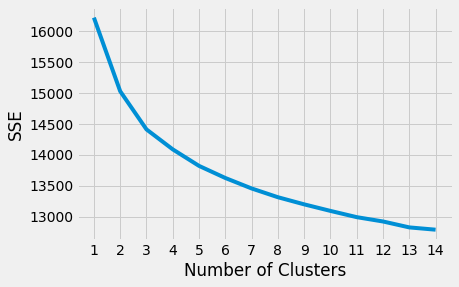

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 15), sse)
plt.xticks(range(1, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kl = KneeLocator(
    range(1, 15), sse, curve="convex", direction="decreasing"
)

kl.elbow


5

In [ ]:
from nltk.tokenize import sent_tokenize
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np

In [ ]:
#n_clusters = np.ceil(len(projected)**0.5)
n_clusters = 5 ##based on elbow-method
kmeans = KMeans(n_clusters=int(n_clusters))
kmeans = kmeans.fit(data_rescaled)
    
sum_index,_ = pairwise_distances_argmin_min(kmeans.cluster_centers_, data_rescaled,metric='euclidean')
    
sum_index = sorted(sum_index)
    
len(sum_index)

5

In [ ]:
# new_data = []
# for i in sum_index:
#     new_data.append(df['review'][i])

In [ ]:

# df['new_review'] = pd.DataFrame(new_data)
# df['new_review']


In [ ]:
df1 = pd.DataFrame()

a = kmeans.predict(data_rescaled)
df['cluster'] = pd.DataFrame(a)

#df['clusters'] = pd.DataFrame(a)
#df = df.drop([998,999])

In [ ]:
#sentences = sent_tokenize(new_data)
sentences = [sent_tokenize(sent) for sent in df['review']]
print(type(sentences))

<class 'list'>


In [ ]:
sentences = ' '.join([str(elem) for elem in sentences])
len(sentences)

251536

In [ ]:
from transformers import pipeline

# load BART summarizer
summarizer = pipeline(task="summarization")

## Split the reviews based on the cluster number

In [ ]:
print(type(df["review"]))

<class 'pandas.core.series.Series'>


In [ ]:
cluster0 = pd.DataFrame()


In [ ]:
num_reviews = df["review"].size
 
reviews_cluster0 = []
reviews_cluster1 = []
reviews_cluster2 = []
reviews_cluster3 = []
reviews_cluster4 = []
summary_cluster0 = []
summary_cluster1 = []
summary_cluster2 = []
summary_cluster3 = []
summary_cluster4 = []
 
 
for i in range( 0, num_reviews ):
    if df["cluster"][i] == 0:
        reviews_cluster0.append(df["Text"][i])
        summary_cluster0.append(df["Summary"][i])

    elif df["cluster"][i] == 1:
        reviews_cluster1.append(df["Text"][i])
        summary_cluster1.append(df["Summary"][i])

    elif df["cluster"][i] == 2:
        reviews_cluster2.append(df["Text"][i])
        summary_cluster2.append(df["Summary"][i])

    elif df["cluster"][i] == 3:
        reviews_cluster3.append(df["Text"][i])
        summary_cluster3.append(df["Summary"][i])
    else:
        if df["cluster"][i] == 4:
            reviews_cluster4.append(df["Text"][i])
            summary_cluster4.append(df["Summary"][i])

        




In [ ]:
print(type(reviews_cluster0))

<class 'list'>


In [ ]:
print(type(reviews_cluster1))

<class 'list'>


Using BERT summarizer for summarization task

## Cluster 0

In [ ]:
cluster0 = pd.DataFrame()

In [ ]:
cluster0= pd.DataFrame(reviews_cluster0)
cluster0 = cluster0.rename(columns={0: "review"})


In [ ]:
# summary_cluster00 = pd.DataFrame(summary_cluster0)
#cluster00 = summary_cluster0.rename(columns={0: "summary"})


In [ ]:
from rouge import Rouge 

from summarizer import Summarizer
model = Summarizer()

In [ ]:
#listToStr = ' '.join([str(elem) for elem in reviews_cluster0]) 


In [ ]:
cluster0 = pd.DataFrame()
cluster0= pd.DataFrame(reviews_cluster0)
cluster0 = cluster0.rename(columns={0: "review"})
# summary_cluster1 = pd.DataFrame(summary_cluster1)
#cluster00 = summary_cluster0.rename(columns={0: "summary"})
#sentences = sent_tokenize(new_data)
sentences0 = [sent_tokenize(sent) for sent in reviews_cluster0]
summary0 = [sent_tokenize(sent) for sent in summary_cluster0]
sentences0 = ' '.join([str(elem) for elem in sentences0])
summary0 = ' '.join([str(elem) for elem in summary0])

In [ ]:
result0 = model(sentences0, ratio=0.5,num_sentences=3)
full0 = ''.join(result0)
print(full0)

['Twizzlers, Strawberry my childhood favorite candy, made in Lancaster Pennsylvania by Y & S Candies, Inc. one of the oldest confectionery Firms in the United States, now a Subsidiary of the Hershey Company, the Company was established in 1845 as Young and Smylie, they also make Apple Licorice Twists, Green Color and Blue Raspberry Licorice Twists, I like them all<br /><br />I keep it in a dry cool place because is not recommended it to put it in the fridge.', ' This is the best instant brand I've ever eaten, and a very close second to the non-instant variety.<br /><br />McCann's Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)"] ['I ordered this for my wife as it was reccomended by our daughter.', ' Some people put a layer of creme patisserie, which is a pastry cream like custard but stabilized with flour,  below the fruit and I happen to think these taste best.<br /><br />If you get into baking, this glaze is a mus

In [ ]:

hypothesis = full0
reference = summary0
rouge = Rouge()
scores0 = rouge.get_scores(hypothesis, reference)
scores0

[{'rouge-1': {'f': 0.1847930668666937,
   'p': 0.4266666666666667,
   'r': 0.11793611793611794},
  'rouge-2': {'f': 0.01735775939027507,
   'p': 0.04017857142857143,
   'r': 0.01107011070110701},
  'rouge-l': {'f': 0.1262553767743291,
   'p': 0.2875816993464052,
   'r': 0.08088235294117647}}]

## Cluster 1

In [ ]:
cluster1 = pd.DataFrame()
cluster1= pd.DataFrame(reviews_cluster1)
cluster1 = cluster1.rename(columns={0: "review"})
# summary_cluster1 = pd.DataFrame(summary_cluster1)
#cluster00 = summary_cluster0.rename(columns={0: "summary"})
#sentences = sent_tokenize(new_data)
sentences1 = [sent_tokenize(sent) for sent in reviews_cluster1]
summary1 = [sent_tokenize(sent) for sent in summary_cluster1]
sentences1 = ' '.join([str(elem) for elem in sentences1])
summary1 = ' '.join([str(elem) for elem in summary1])

In [ ]:
result1 = model(sentences1, ratio=0.5,num_sentences=8)
full1 = ''.join(result1)

In [ ]:

hypothesis = full1
reference = summary1
rouge = Rouge()
scores1 = rouge.get_scores(hypothesis, reference)
scores1

[{'rouge-1': {'f': 0.20224718692710358,
   'p': 0.3535714285714286,
   'r': 0.14163090128755365},
  'rouge-2': {'f': 0.018423742081341545,
   'p': 0.03225806451612903,
   'r': 0.012893982808022923},
  'rouge-l': {'f': 0.13473053499896923,
   'p': 0.25139664804469275,
   'r': 0.09202453987730061}}]

## Cluster 2

In [ ]:
cluster2 = pd.DataFrame()
cluster2= pd.DataFrame(reviews_cluster2)
cluster2 = cluster2.rename(columns={0: "review"})
# summary_cluster1 = pd.DataFrame(summary_cluster1)
#cluster00 = summary_cluster0.rename(columns={0: "summary"})
#sentences = sent_tokenize(new_data)
sentences2 = [sent_tokenize(sent) for sent in reviews_cluster2]
summary2 = [sent_tokenize(sent) for sent in summary_cluster2]
sentences2 = ' '.join([str(elem) for elem in sentences2])
summary2 = ' '.join([str(elem) for elem in summary2])

In [ ]:
result2 = model(sentences2, ratio=0.5,num_sentences=10)
full2 = ''.join(result2)
print(full2)

["Right now I'm mostly just sprouting this so my cats can eat the grass.", ' Ahmad tea is one of my favorite brands and I highly recommend it if you like black tea.', ' For really high end desires, I go with the Apollo Olive Oils from California.', ' The 2 oz bags are a bit big for school lunches, definitely more than a serving.'] [' Maybe it's just nostalgia on my part."] [' These chips are a great snack if you don't want all the junk assiciated with chips.", " We will order these as long as they are available.', ' Thank you for making them accessable.<br /><br />  Shelly Kenyon'] ['They did a very good job with shipping the order quickly....Nothing like Ace Hardware who took a week to ship'] ['I bought thi9s for my dad for a surprise birthday present because he could not find them any where else!', '!'] [' The chocolate is<br />delicious and holds up well to the liquors'] ['I love this flavor and I cant find it on the shelves anymore.', ' being an old chemist with a spectrophotometer

In [ ]:

hypothesis = full2
reference = summary2
rouge = Rouge()
scores2 = rouge.get_scores(hypothesis, reference)
scores2

[{'rouge-1': {'f': 0.1786867560734659,
   'p': 0.33877551020408164,
   'r': 0.12134502923976608},
  'rouge-2': {'f': 0.023732466455758557,
   'p': 0.045081967213114756,
   'r': 0.016105417276720352},
  'rouge-l': {'f': 0.12460063503592987,
   'p': 0.23076923076923078,
   'r': 0.08533916849015317}}]

## Cluster  3

In [ ]:
cluster3 = pd.DataFrame()
cluster3= pd.DataFrame(reviews_cluster3)
cluster3 = cluster3.rename(columns={0: "review"})
# summary_cluster1 = pd.DataFrame(summary_cluster1)
#cluster00 = summary_cluster0.rename(columns={0: "summary"})
#sentences = sent_tokenize(new_data)
sentences3 = [sent_tokenize(sent) for sent in reviews_cluster3]
summary3 = [sent_tokenize(sent) for sent in summary_cluster3]
sentences3 = ' '.join([str(elem) for elem in sentences3])
summary3 = ' '.join([str(elem) for elem in summary3])

In [ ]:
result3 = model(sentences3, ratio=0.5,num_sentences=10)
full3 = ''.join(result3)
print(full3)

['I have bought several of the Vitality canned dog food products and have found them all to be of good quality.', ' i was so impressed that i've ordered some for myself (w dark chocolate) to take to the office so i'll eat them instead of snacking on sugary sweets.<br />These are just EXCELLENT!"] [" I am so glad to have found something that gives me the energy I need without all the chemicals found in other beverages.', " They are a little too vinegary for my taste, which is a lot coming from a kid that grew up eating pickled hard-boiled eggs and pickled pigs feet.<br /><br />I haven't tried them with a deli sandwich and a cold mug of beer which might improve the experience :)"] ['I was hesitant to buy this at my local grocery store, Lunds, but they were on sale, so I bought a bag.', " The only thing I REALLY dislike about these chips (along with the rest of the flavors) is that the serving size is HALF the bag.', ' What a concept.....)  These chips are spicy enough, without burning a 

In [ ]:

hypothesis = full3
reference = summary3
rouge = Rouge()
scores3= rouge.get_scores(hypothesis, reference)
scores3

[{'rouge-1': {'f': 0.18686296393844218,
   'p': 0.46348314606741575,
   'r': 0.11702127659574468},
  'rouge-2': {'f': 0.01814058635422669,
   'p': 0.04507042253521127,
   'r': 0.0113555713271824},
  'rouge-l': {'f': 0.13528336051373796,
   'p': 0.32599118942731276,
   'r': 0.0853517877739331}}]

## Cluster 4 

In [ ]:
cluster4 = pd.DataFrame()
cluster4= pd.DataFrame(reviews_cluster4)
cluster4 = cluster3.rename(columns={0: "review"})
# summary_cluster1 = pd.DataFrame(summary_cluster1)
#cluster00 = summary_cluster0.rename(columns={0: "summary"})
#sentences = sent_tokenize(new_data)
sentences4 = [sent_tokenize(sent) for sent in reviews_cluster4]
summary4 = [sent_tokenize(sent) for sent in summary_cluster4]
sentences4 = ' '.join([str(elem) for elem in sentences4])
summary4 = ' '.join([str(elem) for elem in summary4])

In [ ]:
result4 = model(sentences4, ratio=0.5,num_sentences=10)
full4 = ''.join(result4)
print(full4)

['This is a confection that has been around a few centuries.', ' Six pounds will be around for a while with my son and I.'] ["McCann's Instant Irish Oatmeal, Variety Pack of Regular, Apples & Cinnamon, and Maple & Brown Sugar, 10-Count Boxes (Pack of 6)<br /><br />I'm a fan of the McCann's steel-cut oats, so I thought I'd give the instant variety a try.", " I was buying Quaker Oats granola bars but these Nature Valley chewy bars are better tasting, they make a great snack when I'm on the go.", " Chocolate, peanuts and raisins...it doesn't get any better."] [' All of the markets in my area have made a bargain to carry nothing but McCormacks bland and tasteless seasonings.<br /><br />This is the most flavorful cooking bag mix you will ever find.'] [' I like the sweet onion chips better, but these are also at the top of the list for great-tasting potato chips.', ' They are my favorite because I can season with a variety of spices to exactly suit my tastes without all the salt!'] [' I real

In [ ]:
hypothesis = full4
reference = summary4
rouge = Rouge()
scores4 = rouge.get_scores(hypothesis, reference)
scores4

[{'rouge-1': {'f': 0.20650953566365748,
   'p': 0.3471698113207547,
   'r': 0.14696485623003194},
  'rouge-2': {'f': 0.026996621246304364,
   'p': 0.045454545454545456,
   'r': 0.0192},
  'rouge-l': {'f': 0.13442622548777225,
   'p': 0.2411764705882353,
   'r': 0.09318181818181819}}]